## Customer Churn Prediction for TELCO Company
#### We have customer data of TELCO company with several features.
#### Now, because lots of customers are leaving this company, so as part of customer retention program we need to predict customer churn before they decide to leave.<br/>In order to do that we need to use this data and create machine learning model for customer churn prediction.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Load the data
df = pd.read_csv('Telco-Customer-Churn.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(df.dtypes)

Dataset shape: (7043, 21)
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


#### We have 7043 records with 21 different features including customer id and churn

#### Most of the columns are object type, but for developing model we need numeric values and some label encoding as well, so now we will change datatype of some columns and change string values to numeric values by encoding them.

In [43]:
# Convert 'TotalCharges' to numeric and handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen']=df['SeniorCitizen'].astype(bool)

In [44]:
# Encode categorical features
label_enc_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                  'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                  'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                  'PaperlessBilling', 'PaymentMethod', 'Churn']
for col in label_enc_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

verify data types

In [45]:
print(df.dtypes)

customerID           object
gender                int64
SeniorCitizen          bool
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object


#### There are some categorical values which can be encoded as numbers, so we will take a look at unique values present as categories and convert these fields as category and encode them.

In [46]:
print("Payment methods: ",df.PaymentMethod.unique())
print("Contract types: ",df.Contract.unique())
print("Gender: ",df.gender.unique())
print("Senior Citizen: ",df.SeniorCitizen.unique())
print("Internet Service Types: ",df.InternetService.unique())

Payment methods:  [2 3 0 1]
Contract types:  [0 1 2]
Gender:  [0 1]
Senior Citizen:  [False  True]
Internet Service Types:  [0 1 2]


In [47]:
df['gender']=df['gender'].astype('category')
df['PaymentMethod']=df['PaymentMethod'].astype('category')
df['Contract']=df['Contract'].astype('category')
df['SeniorCitizen']=df['SeniorCitizen'].astype('category')
df['InternetService']=df['InternetService'].astype('category')
df.dtypes

customerID            object
gender              category
SeniorCitizen       category
Partner                int64
Dependents             int64
tenure                 int64
PhoneService           int64
MultipleLines          int64
InternetService     category
OnlineSecurity         int64
OnlineBackup           int64
DeviceProtection       int64
TechSupport            int64
StreamingTV            int64
StreamingMovies        int64
Contract            category
PaperlessBilling       int64
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn                  int64
dtype: object

#### Here we have encoded fields with numbers by pandas build-in get_dummies method, and using that method we need to give prefix for new fields which will be generated.
#### This method will generate new fields with prefix and category name as column name and 0 or 1 will be their value.
#### As we can see below, we got all the new fields with values as 0 or 1.

In [48]:
dfPaymentDummies = pd.get_dummies(df['PaymentMethod'], prefix = 'payment')
dfContractDummies = pd.get_dummies(df['Contract'], prefix = 'contract')
dfGenderDummies = pd.get_dummies(df['gender'], prefix = 'gender')
dfSeniorCitizenDummies = pd.get_dummies(df['SeniorCitizen'], prefix = 'SC')
dfInternetServiceDummies = pd.get_dummies(df['InternetService'], prefix = 'IS')

print(dfPaymentDummies.head(3))
print(dfContractDummies.head(3))
print(dfGenderDummies.head(3))
print(dfSeniorCitizenDummies.head(3))
print(dfInternetServiceDummies.head(3))

   payment_0  payment_1  payment_2  payment_3
0      False      False       True      False
1      False      False      False       True
2      False      False      False       True
   contract_0  contract_1  contract_2
0        True       False       False
1       False        True       False
2        True       False       False
   gender_0  gender_1
0      True     False
1     False      True
2     False      True
   SC_False  SC_True
0      True    False
1      True    False
2      True    False
   IS_0   IS_1   IS_2
0  True  False  False
1  True  False  False
2  True  False  False


#### Now we have new dataframes by label encoding, so we will concat them with our existing dataframe, but before that we will remove category fields as we don't need them right!

In [49]:
df.drop(['gender','PaymentMethod','Contract','SeniorCitizen','InternetService'], axis=1, inplace=True)

df = pd.concat([df, dfPaymentDummies], axis=1)
df = pd.concat([df, dfContractDummies], axis=1)
df = pd.concat([df, dfGenderDummies], axis=1)
df = pd.concat([df, dfSeniorCitizenDummies], axis=1)
df = pd.concat([df, dfInternetServiceDummies], axis=1)
df.head(2)

,customerID,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,contract_0,contract_1,contract_2,gender_0,gender_1,SC_False,SC_True,IS_0,IS_1,IS_2
0,7590-VHVEG,1,0,1,0,1,0,2,0,0,...,True,False,False,True,False,True,False,True,False,False
1,5575-GNVDE,0,0,34,1,0,2,0,2,0,...,False,True,False,False,True,True,False,True,False,False


#### For a bit of simplicity, we'll rename some column names

In [50]:
df.columns = ['customerID', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'Churn',
       'payment_Bank_transfer_auto', 'payment_Credit_card_auto',
       'payment_Electronic_check', 'payment_Mailed_check',
       'contract_Month_to_month', 'contract_One_year', 'contract_Two_year',
       'gender_Female', 'gender_Male', 'SC_False', 'SC_True', 'IS_DSL',
       'IS_Fiber_optic', 'IS_No']

#### We'll convert all fields to number type in dataframe for our model.
#### Here we are wrapping up data preparation phase.

In [51]:
numericColumns=np.array(['Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'Churn',
       'payment_Bank_transfer_auto', 'payment_Credit_card_auto',
       'payment_Electronic_check', 'payment_Mailed_check',
       'contract_Month_to_month', 'contract_One_year', 'contract_Two_year',
       'gender_Female', 'gender_Male', 'SC_False', 'SC_True', 'IS_DSL',
       'IS_Fiber_optic', 'IS_No'])

for columnName in numericColumns:
    df[columnName]=pd.to_numeric(df[columnName],errors='coerce')
df.dtypes

customerID                     object
Partner                         int64
Dependents                      int64
tenure                          int64
PhoneService                    int64
MultipleLines                   int64
OnlineSecurity                  int64
OnlineBackup                    int64
DeviceProtection                int64
TechSupport                     int64
StreamingTV                     int64
StreamingMovies                 int64
PaperlessBilling                int64
MonthlyCharges                float64
TotalCharges                  float64
Churn                           int64
payment_Bank_transfer_auto       bool
payment_Credit_card_auto         bool
payment_Electronic_check         bool
payment_Mailed_check             bool
contract_Month_to_month          bool
contract_One_year                bool
contract_Two_year                bool
gender_Female                    bool
gender_Male                      bool
SC_False                         bool
SC_True     

#### We'll save our model data to new csv file without customerID, as we won't be using that in our model development.

In [52]:
modelData = df.loc[:, df.columns != 'customerID']
modelData.to_csv('modelData.csv')

### <b>Model Development</b>
#### After reading our model data, we'll take our training and target data in numpy arrays

In [53]:
modelData=pd.read_csv('modelData.csv')

modelData[modelData==np.inf]=np.nan
modelData.fillna(modelData.mean(), inplace=True)

x=np.asarray(modelData.loc[:,modelData.columns != 'Churn'])
y=np.asarray(modelData['Churn'])

print(x[:2])
print(y[:2])

[[0 1 0 1 0 1 0 2 0 0 0 0 1 29.85 29.85 False False True False True False
  False True False True False True False False]
 [1 0 0 34 1 0 2 0 2 0 0 0 0 56.95 1889.5 False False False True False
  True False False True True False True False False]]
[0 0]


#### Here we'll normalize our data by using sklearn's StandardScaler

In [54]:
from sklearn import preprocessing
x = preprocessing.StandardScaler().fit(x).transform(x)
x[0:2]

array([[-1.7318049 ,  1.03453023, -0.65401193, -1.27744458, -3.05401039,
         0.06272275, -0.91883775,  1.24254983, -1.02791014, -0.92526212,
        -1.11349541, -1.12140513,  0.8297975 , -1.16032292, -0.99497138,
        -0.5298852 , -0.52504733,  1.40641839, -0.54480692,  0.90418382,
        -0.51424938, -0.56297505,  1.00955867, -1.00955867,  0.43991649,
        -0.43991649,  1.38171215, -0.88565976, -0.52592737],
       [-1.73131305, -0.96662231, -0.65401193,  0.06632742,  0.32743831,
        -0.9915883 ,  1.40732123, -1.02991925,  1.24511061, -0.92526212,
        -1.11349541, -1.12140513, -1.20511329, -0.25962894, -0.17387565,
        -0.5298852 , -0.52504733, -0.71102597,  1.83551265, -1.1059698 ,
         1.94458183, -0.56297505, -0.99053183,  0.99053183,  0.43991649,
        -0.43991649,  1.38171215, -0.88565976, -0.52592737]])

#### It is recommended practice of splitting data in training and testing before using it in model, in our case we are keeping 80/20 data for training and testing respectively.

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=72)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (5634, 29) (5634,)
Test set: (1409, 29) (1409,)


#### Before fitting data to our model, feature selection is very essential part of model development.
#### Here we are using sklearn's RandomForestClassifier with ensemble learning to choose most relevent features for our model. It will iteratively select most relevent features and eliminate least relevent features and threshold will be median for feature selection.

In [56]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler


print((X_train < 0).any().any())  


X_train_non_negative = X_train - X_train.min() + 1
X_test_non_negative = X_test - X_test.min() + 1


selector = SelectKBest(chi2, k=15)
X_train_selected = selector.fit_transform(X_train_non_negative, y_train)
X_test_selected = selector.transform(X_test_non_negative)

print('The shape of X_train: ', X_train.shape)
print('The shape of X_train_selected: ', X_train_selected.shape)


True
The shape of X_train:  (5634, 29)
The shape of X_train_selected:  (5634, 15)


#### As we can see in above feature selection process, we got 15 most relevent features out of 29 from our training data.
#### We can see here black colored area shows all those features are relevent and selected.

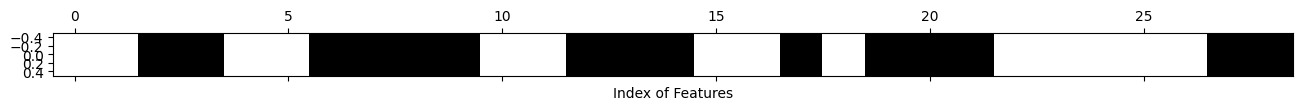

In [57]:
mask = selector.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Index of Features')
plt.show()

In this step, we are training a logistic regression model. Logistic regression is a widely used statistical method for binary classification problems, such as predicting whether a customer will churn (leave the company) or not. 

We use the fit method to train the model on our selected features from the training dataset (X_train_selected) and the target variable (y_train). 

The random_state parameter is set to ensure the results are reproducible.

In [58]:
model = LogisticRegression(random_state=37)
model.fit(X_train_selected, y_train)

LogisticRegression(random_state=37)

In the feature selection process, we used SelectKBest with a chi-square test to select the 15 most relevant features out of the original 29 features from our training data. 

This method helps in reducing the dimensionality of the dataset by selecting only the most significant features, which can lead to improved model performance and reduced computational complexity.

In [59]:
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'model' is already defined and fitted
y_pred = model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Logistic Regression for customer churn: {accuracy:.3f}')
print(classification_report(y_test, y_pred))

Accuracy of Logistic Regression for customer churn: 0.800
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1027
           1       0.66      0.53      0.59       382

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



#### We're fitting our training data to LogicalRegression and making prediction on our test data.
#### Accuracy of our model is around 80%, and that means 80/100 times we can make correct prediction.

In [60]:
select = StandardScaler()
X_train_s = select.fit_transform(X_train)
X_test_s = select.transform(X_test)

# Train and evaluate the Logistic Regression model
lr = LogisticRegression()
score = lr.fit(X_train_s, y_train).score(X_test_s, y_test)
print('The score of Logistic Regression for customer churn: {:.3f}'.format(score))

The score of Logistic Regression for customer churn: 0.803
